In [1]:
# Import all libraries

import pandas as pd
import numpy as np
import glob
import os
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
rstate = 2
path = '../data_engineering/outputs/sales/'

In [3]:
# load the data
parquet_files = glob.glob(os.path.join(path, "*.parquet"))
data = pd.concat((pd.read_parquet(f) for f in parquet_files))

inputs = data[['sqfeet',
              'beds',
              'baths',
              'income',
              'density']]

scaler = MinMaxScaler()
scaler.fit(inputs)
pickle.dump(scaler, open('./outputs/sale_models_scaled_poly/scaler.pkl', 'wb'))

inputs_scaled = scaler.transform(inputs)
              
outputs = data['price']

In [4]:
inputs_scaled

array([[7.95918367e-01, 4.28571429e-01, 4.28571429e-01, 4.31561498e-01,
        7.68363469e-03],
       [5.96734694e-01, 2.85714286e-01, 2.85714286e-01, 4.31561498e-01,
        7.68363469e-03],
       [2.65306122e-01, 2.85714286e-01, 2.85714286e-01, 4.31561498e-01,
        7.68363469e-03],
       ...,
       [2.45306122e-01, 2.85714286e-01, 1.42857143e-01, 1.04912015e-01,
        3.54950516e-04],
       [2.45306122e-01, 2.85714286e-01, 1.42857143e-01, 1.04912015e-01,
        3.54950516e-04],
       [2.45306122e-01, 2.85714286e-01, 1.42857143e-01, 1.04912015e-01,
        3.54950516e-04]])

In [5]:
data.describe()

,sqfeet,beds,baths,income,density,price
count,546794.000000,546794.000000,546794.000000,546794.000000,546794.000000,5.467940e+05
mean,1820.117699,3.073077,2.314281,70652.892645,13422.753906,8.249511e+05
std,924.363580,1.346245,1.085194,28247.310344,24667.255859,1.336170e+06
min,100.000000,1.000000,1.000000,11368.000000,1.000000,5.000000e+02
25%,1126.000000,2.000000,2.000000,49740.000000,521.000000,2.960000e+05
50%,1600.000000,3.000000,2.000000,66583.000000,2256.000000,4.899000e+05
75%,2314.000000,4.000000,3.000000,86346.000000,13251.000000,8.390000e+05
max,5000.000000,8.000000,8.000000,230952.000000,143683.000000,4.500000e+07


In [6]:
import itertools
import matplotlib.pyplot as plt


def graph_dist(inputs):
    labels = ['sqfeet',
              'beds',
              'baths',
              'income',
              'density']
    
    fig,axs = plt.subplots(1,5,figsize=(25,5))
    for i in range(5):
        axs[i].scatter(inputs[labels[i]],inputs['price'])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("Price")
    plt.tight_layout()
    return fig, axs


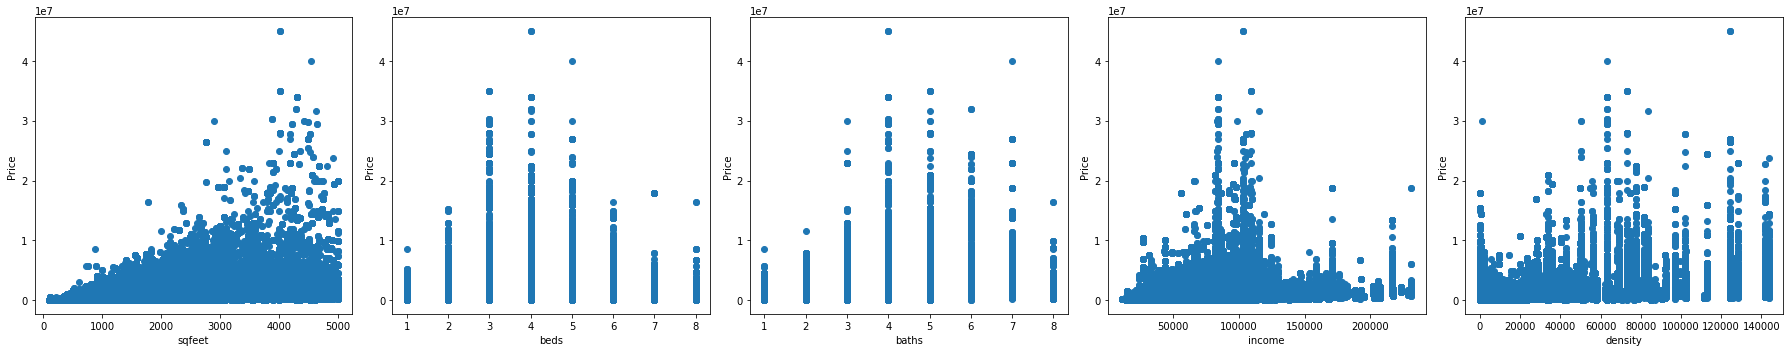

In [7]:
fig, axs = graph_dist(data)

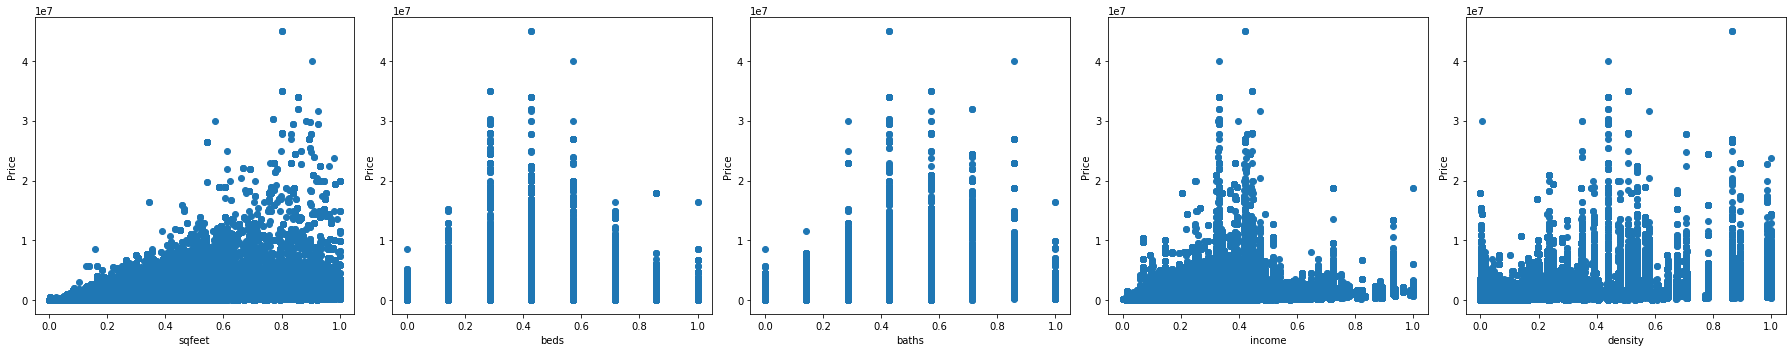

In [8]:

def graph_dist(inputs):
    labels = ['sqfeet',
              'beds',
              'baths',
              'income',
              'density']
    ipt = pd.DataFrame(inputs_scaled, columns=labels)
    fig,axs = plt.subplots(1,5,figsize=(25,5))
    for i in range(5):
        axs[i].scatter(ipt[labels[i]],inputs['price'])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("Price")
    plt.tight_layout()
    return fig, axs
fig, axs = graph_dist(data)

In [9]:
poly = PolynomialFeatures(2)
inputs2 = poly.fit_transform(inputs_scaled)
pickle.dump(poly, open('./outputs/sale_models_scaled_poly/poly.pkl', 'wb'))

In [10]:
len(inputs2[0])

21

In [11]:
x_train, x_test, y_train, y_test = train_test_split(inputs2, outputs, test_size = 0.2, random_state=rstate)

### Trying Models, evaluating, and saving them

Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

linmodel = LinearRegression()
linmodel.fit(x_train, y_train)

LinearRegression()

In [13]:
linmodel.score(x_test, y_test)

0.6406324497872048

In [14]:
linmodel.predict(x_test)

array([ 285282.08525039,  742099.14219916,  964948.84567971, ...,
        799681.39356063, 1558353.67139746,  822112.48787278])

In [15]:
ridgemodel = Ridge()
ridgemodel.fit(x_train, y_train)

Ridge()

In [16]:
ridgemodel.score(x_test, y_test)

0.6405660387784734

In [17]:
ridgemodel.predict(x_test)

array([ 282750.6182257 ,  742349.99037001,  968763.09397643, ...,
        802460.74861256, 1558264.31445082,  818413.10227307])

In [18]:
lassomodel = Lasso()
lassomodel.fit(x_train, y_train)

Lasso()

In [19]:
lassomodel.score(x_test, y_test)

0.6406288126976472

In [20]:
lassomodel.predict(x_test)

array([ 285076.2290793 ,  742160.11424804,  964907.48634395, ...,
        799609.47923112, 1558358.79675297,  821935.29094418])

In [21]:
import eli5
eli5.show_weights(lassomodel)

Weight?,Feature
+19366996.862,x10
+5358624.142,x17
+5019715.784,x19
+4204062.640,x8
+2229818.408,x9
+1687030.329,x11
+1495062.001,x16
+1007687.487,x4
+986407.085,x13
+555227.909,x2


In [22]:
pickle.dump(linmodel, open('./outputs/sale_models_scaled_poly/linmodel_2.pkl', 'wb'))
pickle.dump(ridgemodel, open('./outputs/sale_models_scaled_poly/ridgemodel_2.pkl', 'wb'))
pickle.dump(lassomodel, open('./outputs/sale_models_scaled_poly/lassomodel_2.pkl', 'wb'))

Tensorflow Neural Network

In [23]:
# Keras NN model to be created
def create_model(inputs, outputs):
    input_layer = Input(shape=(21, ))
    x1 = Dense(15, activation='relu', kernel_initializer='normal') (input_layer)
    x2 = Dense(5, activation='relu', kernel_initializer='normal') (x1)
    x3 = Dense(3, activation='relu', kernel_initializer='normal') (x2)
    output = Dense(1, activation='linear', kernel_initializer='normal') (x3)

    t_model = Model(inputs=input_layer, outputs=output)

    t_model.compile(
        loss='mean_squared_error', 
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mean_squared_error"]
    )
    
    t_model.fit(inputs, outputs, epochs=350, batch_size=1000, verbose=True)
    return t_model

In [24]:
nn_model = create_model(x_train, y_train)

2022-12-07 10:06:40.334917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/350
438/438 [==============================] - 1s 2ms/step - loss: 2443811749888.0000 - mean_squared_error: 2443811749888.0000
Epoch 2/350
438/438 [==============================] - 1s 2ms/step - loss: 2443810177024.0000 - mean_squared_error: 2443810177024.0000
Epoch 3/350
438/438 [==============================] - 1s 2ms/step - loss: 2443810701312.0000 - mean_squared_error: 2443810701312.0000
Epoch 4/350
438/438 [==============================] - 1s 2ms/step - loss: 2443809914880.0000 - mean_squared_error: 2443809914880.0000
Epoch 5/350
438/438 [==============================] - 1s 2ms/step - loss: 2443808866304.0000 - mean_squared_error: 2443808866304.0000
Epoch 6/350
438/438 [==============================] - 1s 2ms/step - loss: 2443807293440.0000 - mean_squared_error: 2443807293440.0000
Epoch 7/350
438/438 [==============================] - 1s 3ms/step - loss: 2443807555584.0000 - mean_squared_error: 2443807555584.0000
Epoch 8/350
438/438 [==============================] - 

In [25]:
y_pred = nn_model.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-0.36695332907587974

In [26]:
nn_model.evaluate(x_test, y_test)

3418/3418 [==============================] - 4s 1ms/step - loss: 2553945260032.0000 - mean_squared_error: 2553945260032.0000


[2553945260032.0, 2553945260032.0]

In [27]:
nn_model.save('./outputs/sale_models_scaled_poly/nn_model_2.h5')